In [21]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os
import torchvision
from matplotlib import pyplot as plt 
from sklearn. metrics import f1_score
from tqdm import tqdm, tqdm_notebook
import math
from torch.optim.optimizer import Optimizer
from torch import Tensor
from torchmetrics import F1Score
import torch
import torch.nn as nn
from typing import List, Optional
from torch import Tensor
from PIL import Image
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [22]:
MNIST_train = torchvision.datasets.MNIST('./', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST('./', download=True, train=False)
#MNIST_train = torchvision.datasets.ImageNet('./', split='train')
#MNIST_test = torchvision.datasets.ImageNet('./', split='val')

60000


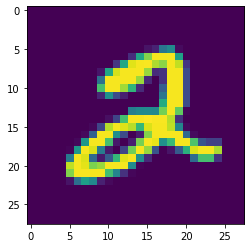

In [23]:
print(len(MNIST_train.train_labels))
plt.imshow(MNIST_train.train_data[5]/255)

In [24]:
class create_dataset():
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.len = len(self.data)
        
    def __getitem__(self, index):
        img = self.data[index]
        img = img.numpy()
        #print(img.shape)
        img = Image.fromarray(img)
        img = img.resize((227,227), Image.BILINEAR)
        img = np.array(img)
        img = img.reshape((1,227,227))
        img = np.array(img)
        # нормализуем
        img = img / 255
        
        return img, int(self.labels[index])
    
    def __len__(self):
        return self.len

In [25]:
def loader_data (dataset, num_batch):
        data = []
        amount = len(dataset) // num_batch
        for i in range(amount):
            batch_img = []
            batch_tar = []
            if i != amount:
                for j in range(num_batch):
                    batch_img.append(dataset[i*j][0])
                    batch_tar.append(dataset[i*j][1])
            else:
                for j in range(len(dataset)-amount*num_batch):
                    batch_img.append(dataset[i*j][0])
                    batch_tar.append(dataset[i*j][1])
            data.append((np.array(batch_img), np.array(batch_tar)))
        return data

In [26]:
train_data = create_dataset(MNIST_train.train_data[:50], MNIST_train.train_labels[:50])
train_dataset = loader_data(train_data, 10)
val_data = create_dataset(MNIST_train.test_data[:20], MNIST_train.test_labels[:20])
val_dataset = loader_data(val_data, 10)
dataloader = {'train':train_dataset, 'val':val_dataset}

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  del sys.path[0]


In [27]:
# класс свертки
class convolution():
    def __init__(self, in_channels, out_channels, kernel_size, padding = [0,0], stride = [1,1]):
        #self.width_in, self.height_in, _ = image.shape
        self.size_padding = padding
        self.size_stride_x = stride[0]
        self.size_stride_y = stride[1]
        self.width_filter = kernel_size[0]
        self.height_filter = kernel_size[1]
        self.num_in_channels = in_channels
        self.num_out_channels = out_channels
        self.type = 'conv'
        #self.width_channel = (self.width_in - self.width_filter + 2*size_padding)/size_stride + 1
        #self.height_channel = (self.height_in - self.height_filter + 2*size_padding)/size_stride + 1
        
        self.filters = np.array([[[[random.random() for width in range(self.width_filter)] for height in range(self.height_filter)] 
                        for deep in range(self.num_in_channels)] for num_filter in range(self.num_out_channels)])
        self.bias = np.array([1 for i in range(self.num_out_channels)])
    def __call__(self, in_image):
        self.input = in_image
        #print(np.array(in_image).shape)
        #print(len(in_image[0]), self.width_filter, self.size_padding[0], self.size_stride_x)
        size_bach, kanals, y, x = np.array(in_image).shape
        x_layer = int((x - self.width_filter + 2*self.size_padding[0])/self.size_stride_x + 1)
        y_layer = int((y - self.height_filter + 2*self.size_padding[0])/self.size_stride_y + 1)
        bach_image = []
        for ind in range(size_bach):
            one_image = in_image[ind]
            #print(np.array(one_image).shape)
            pad_image = []
            for i in range(kanals):
                
                if self.size_padding!=[0,0]:
                    #print('asd')
                    #print(self.size_padding)
                    pad_image.append(self.padding(one_image[i]))
                else:
                    pad_image.append(one_image[i])
            one_image = np.array(pad_image)
            #print(one_image.shape)
            kanals, y, x = np.array(one_image).shape
            #y = in_image.shape[1] - self.height_filter + 1
            #x = in_image.shape[0] - self.width_filter + 1
            out_filter = np.zeros((x_layer,y_layer), float)
            #out_channel = np.zeros(x,y,self.num_in_channels)
            #out_image = np.zeros(x,y,self.num_in_channels, self.num_out_channels)
            out_image = []
            for num_filter in range(self.num_out_channels):
                out_channel = []
                for deep_filter in range(self.num_in_channels):
                    x_step = 0
                    y_step = 0
                    image = one_image[deep_filter]
                    for h in range(0, y, self.size_stride_y):
                        for w in range(0, x, self.size_stride_x):
                            out_filter[x_step][y_step] = np.sum(image[w:w + self.width_filter, h:h + self.height_filter]*self.filters[:][:][num_filter][deep_filter])
                        
                            x_step = x_step + 1
                            if x_step == x_layer:
                                break
                        y_step = y_step + 1
                        x_step = 0
                        if y_step == y_layer:
                            break
                
                    out_channel.append(out_filter.copy())
                
                #out_channel = []
            #print(out_channel)
                out_filter_result = np.zeros((x_layer,y_layer), float)
                for matrix in out_channel:
                    out_filter_result = np.add(out_filter_result, matrix)
                out_filter_result = np.add(out_filter_result, self.bias[num_filter])
                out_image.append(out_filter_result.copy())
            #print()
            bach_image.append(out_image.copy())
        #print(out_image)
        #print(np.array(bach_image).shape)
        return np.array(bach_image)
    def padding(self, in_image, pad = None, full = 0):
        #print(self.size_padding)
        if pad is None:
            return np.pad(in_image, pad_width=[[self.size_padding[0],self.size_padding[0]],[self.size_padding[1],self.size_padding[1]]], mode='constant', constant_values=0)
        else:
            padd = []
            for i in range(in_image.shape[0]):
                arr = np.full((in_image.shape[1],in_image.shape[2]+2*pad,in_image.shape[3]+2*pad),full)
                arr[:, pad:-pad,pad:-pad] = in_image[i]
                padd.append(arr)
            return np.array(padd)
    def __str__(self):
        return self.type
    
    # вычисление размерности
    def calc_out_shape(self, input_matrix_shape, out_channels, kernel_size, stride, padding):
        if padding == None:
            padding = 0
        out_shape = [input_matrix_shape[0], out_channels, (input_matrix_shape[2]+2*padding-kernel_size)//stride+1,
                 (input_matrix_shape[3]+2*padding-kernel_size)//stride+1] 
        return np.array(out_shape)
    # параметры слоя
    def get_params(self):
        return [self.filters, self.bias]
    # обновляем веса
    def update_weights(self, new_params):
        self.filters, self.bias = new_params
    # вычисляем обратное распространение 
    def backward(self, prev_grad):
        dx = np.zeros_like(self.input)
        dw = np.zeros_like(self.filters)
        db = np.zeros_like(self.bias)
        db = np.sum(prev_grad, axis = (0, 2, 3))
        
        N, C, H, W = self.input.shape
        F, _, HH, WW = self.filters.shape
        _, _, H_, W_ = prev_grad.shape
        
        w_ = np.zeros_like(dw)
        for i in range(HH):
            for j in range(WW):
                w_[:,:,i,j] = self.filters[:,:,HH-i-1,WW-j-1]
        if self.size_padding!=[0,0]:
            pad = self.size_padding[0]
            input_w_pad = self.padding(self.input, pad) 
            dx_w_pad = self.padding(dx, pad) 
        else:
            pad = 0
            input_w_pad = self.input
            dx_w_pad = dx 
            
        pred_grad_w_pad =  self.padding(prev_grad, pad = WW-1) # реализация для квадратных изображений и ядер свертки
    
        for n in range(N):       
            for f in range(F):   
                for i in range(HH): 
                    for j in range(WW):
                        for k in range(H_): 
                            for l in range(W_):
                                for c in range(C): 
                                    dw[f,c,i,j] += input_w_pad[n, c, self.size_stride_x*i+k, self.size_stride_y*j+l] * prev_grad[n, f, k, l]
    
                for i in range(H+2*pad):
                    for j in range(W+2*pad):
                        for k in range(HH):
                            for l in range(WW):
                                for c in range(C): 
                                    dx_w_pad[n,c,i,j] += pred_grad_w_pad[n, f, i+k, j+l] * w_[f, c, k, l]
        if self.size_padding!=[0,0]:
            dx = dx_w_pad[:,:,pad:-pad,pad:-pad]
        else: dx = dx_w_pad
        return dx, dw, db

In [28]:
# класс макспулинга
class MaxPool2d():
    def __init__(self, kernel_size, padding = [0,0], stride = [1,1]):
        self.size_padding = padding
        self.size_stride_x = stride[0]
        self.size_stride_y = stride[1]
        self.width_filter = kernel_size[0]
        self.height_filter = kernel_size[1]
        self.type = 'maxpool'
        self.kernel_size = kernel_size
        
    def padding(self, in_image):
        return np.pad(in_image, pad_width=[[self.size_padding[0],self.size_padding[0]],[self.size_padding[1],self.size_padding[1]]], mode='constant', constant_values=0)
    
    def __call__(self, in_image):
        self.input = in_image
        size_bach, kanals, y, x = np.array(in_image).shape
        
        x_layer = int((x - self.width_filter + 2*self.size_padding[0])/self.size_stride_x + 1)
        y_layer = int((y - self.height_filter + 2*self.size_padding[0])/self.size_stride_y + 1)
        bach_image = []
        for ind in range(size_bach):
            one_image = in_image[ind]
            #print(np.array(one_image).shape)
            pad_image = []
            for i in range(kanals):
                pad_image.append(self.padding(one_image[i]))
            one_image = np.array(pad_image)
            #in_image = self.padding(in_image)
            kanals, y, x = np.array(one_image).shape
            out_channel = np.zeros((x_layer,y_layer), float)
            out_image = []
            for kanal in range(kanals):
            
                x_step = 0
                y_step = 0
                image = one_image[kanal]
                for h in range(0, y, self.size_stride_y):
                    for w in range(0, x, self.size_stride_x):
                        out_channel[x_step][y_step] = max(map(max, image[w:w + self.width_filter, h:h + self.height_filter]))
                        x_step = x_step + 1
                        if x_step == x_layer:
                            break
                    y_step = y_step + 1
                    x_step = 0
                    if y_step == y_layer:
                        break
            
                #out_channel = []
            #print(out_channel)
                out_image.append(out_channel.copy())
            #print()
            bach_image.append(out_image)
        #print(out_image)
        self.size = np.array(bach_image).shape
        return np.array(bach_image)
        
    def __str__(self):
        return self.type
    
    def backward(self, prev_grad):
        if prev_grad.shape != self.size:
            prev_grad = np.reshape(self.size)
        N, C, H, W =prev_grad.shape
        dx = np.zeros_like(self.input)
        
        for n in range(N):
            for c in range(C):
                for i in range(H):
                    for j in range(W):
                        i_t, j_t = np.where(np.max(self.input[n, c, i * self.size_stride_x : i * self.size_stride_x + self.width_filter, j * self.size_stride_y : j * self.size_stride_y + self.height_filter]) == self.input[n, c, i * self.size_stride_x : i * self.size_stride_x + self.width_filter, j * self.size_stride_y : j * self.size_stride_y + self.height_filter])
                        i_t, j_t = i_t[0], j_t[0]
                        dx[n, c, i * self.size_stride_x : i * self.size_stride_x + self.width_filter, j * self.size_stride_y : j * self.size_stride_y + self.kernel_size[1]][i_t, j_t] = prev_grad[n, c, i, j]
        return dx

In [29]:
# класс линейной вертки
class Linear():
    def __init__(self, input_size, out_size):
        self.input_neurons = input_size
        self.out_neurons = out_size
        self.weight = np.array([[random.random() for width in range(self.input_neurons)] for height in range(self.out_neurons)])
        #print( self.weight.shape)
        self.bias = np.array([1 for i in range(self.out_neurons)])
        self.type = 'linear'
        
    def __call__(self, in_image):
        self.input = in_image
        result = []
        #print(in_image.shape)
        for ind in range(in_image.shape[0]):
            summ = np.matmul(self.weight, in_image[ind]) + self.bias
            result.append(summ)
        return np.array(result)
    
    #def relu(self, summ_b):
    #    return np.maximum(0, summ_b)
    
    #def softmax(self, x):
    ##    y = np.exp(x - np.max(x, axis=1, keepdims=True))
    #   return y / np.sum(y, axis=1, keepdims=True)
    
    def __str__(self):
        return self.type
    
    def get_params(self):
        return [self.weight, self.bias]
    
    def update_weights(self, new_params):
        self.weight, self.bias = new_params
        
    def backward(self,prev_grad):
        dw = np.dot(prev_grad.T, self.input)
        db = prev_grad.mean(axis=0, keepdims=True)
        db = db.reshape(db.shape[1])
        dx = np.dot(  self.weight.T, prev_grad.T).T

        assert (dx.shape == self.input.shape)
        assert (dw.shape == self.weight.shape)
        assert (db.shape == self.bias.shape)
        return dx, dw, db

In [30]:
# функция активации
class relu():
    def __init__(self, inplace = False):
        self.inplace = inplace
        self.type = 'relu'
        
    def __call__(self, in_image):
        self.input = in_image
        result = []
        for i in range(in_image.shape[0]):
            result.append(np.maximum(0, in_image[i]))
        return np.array(result)
    
    def __str__(self):
        return self.type
    
    def backward(self, grad):
        grad = grad.reshape(self.input.shape)
        return np.where(self.input>0,grad,0)


In [31]:
# класс софтмакса
class softmax():
    def __init__(self, dim):
        self.dim = dim
        self.type = 'softmax'
    
    def __str__(self):
        return self.type
    
    def __call__(self, x):
        y = np.exp(x - np.max(x, axis=1, keepdims=True))
        return y / np.sum(y, axis=1, keepdims=True)
    
    def backward(self, prev_grad):
        return prev_grad

In [32]:
# функция ошибки
class CrossEntropyLoss():
    def __init__(self):
        pass
    def __call__(self, y_pred, y_true):
        true_class_logits = y_pred[np.arange(len(y_pred)), y_true]
        cross_entropy = - true_class_logits + np.log(np.sum(np.exp(y_pred), axis=-1))
        return np.mean(cross_entropy)
        
        
    def backward(self, y_pred, y_true):
        ones_true_class = np.zeros_like(y_pred)
        ones_true_class[np.arange(len(y_pred)),y_true] = 1
        softmax = np.exp(y_pred) / np.exp(y_pred).sum(axis=-1,keepdims=True)
        return (-ones_true_class + softmax) / y_pred.shape[0]

In [33]:
def Flatten(in_image):
    arr = []
    for i in range(in_image.shape[0]):
        arr.append(in_image[i].flatten())
    return np.array(arr)

In [34]:
class Adam():
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        self.params = np.array(params)
        self.lr = lr
        self.beta1, self.beta2 = betas
        self.eps = eps
        self.weight_decay = weight_decay
        
        self.steps = np.zeros(len(self.params))
        self.exp_avg = np.zeros_like(self.params)
        self.exp_avg_sq = np.zeros_like(self.params)
        
    def __call__(self,):
        pass
                
    def step(self, grads):
        for i in range(len(self.params)):
            grad = grads[i]  # получаем градиенты слоя модели
            
            if self.steps[i] == 0:
                # Momentum 
                self.exp_avg[i] = np.zeros_like(self.params[i])
                # RMS Prop componenet. 
                self.exp_avg_sq[i] = np.zeros_like(self.params[i])
                    
            self.steps[i] += 1
            if self.weight_decay != 0:
                    grad = grad.add(self.weight_decay, self.params[i])
            
            # Momentum
            self.exp_avg[i][0] = np.multiply(self.exp_avg[i][0], self.beta1) + (1 - self.beta1) * grad[0]
            self.exp_avg[i][1] = np.multiply(self.exp_avg[i][1], self.beta1) + (1 - self.beta1) * grad[1]
            # RMS
            self.exp_avg_sq[i][0] = np.multiply(self.exp_avg_sq[i][0], self.beta2) + (1-self.beta2)*(grad[0]*grad[0])
            self.exp_avg_sq[i][1] = np.multiply(self.exp_avg_sq[i][1], self.beta2) + (1-self.beta2)*(grad[1]*grad[1])
            
            self.exp_avg_sq[i][0] = self.exp_avg_sq[i][0].astype('float')
            self.exp_avg_sq[i][1] = self.exp_avg_sq[i][1].astype('float')
            
            denom_w = np.sqrt(self.exp_avg_sq[i][0]) + self.eps
            denom_b = np.sqrt(self.exp_avg_sq[i][1]) + self.eps

            bias_correction1 = 1 / (1 - self.beta1 ** self.steps[i])
            bias_correction2 = 1 / (1 - self.beta2 ** self.steps[i])
                
            adapted_learning_rate = self.lr * bias_correction1 / math.sqrt(bias_correction2)

            self.params[i][0] = self.params[i][0] - adapted_learning_rate * self.exp_avg[i][0] / denom_w
            self.params[i][1] = self.params[i][1] - adapted_learning_rate * self.exp_avg[i][1] / denom_b
        return self.params       
        

In [35]:
class AdaSmooth(Optimizer):
    def __init__(self, params, lr = 0.001, p1 = 0.5, p2 = 0.99, eps=1e-6, weight_decay=0, M = None ):
        if not lr >= 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not p2 >= p1:
            raise ValueError("p2 must be > p1: p2 = {}, p1 = {}".format(p2, p1))
        if not  eps >= 0.0:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not weight_decay >= 0.0:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))

        defaults = dict(lr=lr, 
                        p1=p1,
                        p2=p2, 
                        eps=eps, 
                        weight_decay=weight_decay,
                        M = M)
        super(AdaSmooth, self).__init__(params, defaults)

    def __setstate__(self, state):
        super().__setstate__(state)

    @torch.no_grad()
    def step(self, closure=None):

        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            params_with_grad = []
            grads = []
            norm_terms = []
            xt = []
            st = []
            nt = []
            lr, p1, p2, eps, weight_decay, M = (group['lr'],
                                            group['p1'],
                                            group['p2'],
                                            group['eps'],
                                            group['weight_decay'],
                                            group['M'])

            for p in group['params']:
                if p.grad is None:
                    continue
                params_with_grad.append(p)
                if p.grad.is_sparse:
                    raise RuntimeError('Adasmooth does not support sparse gradients')
                grads.append(p.grad)

                state = self.state[p]

                # Lazy state initialization
                if len(state) == 0:
                    state['step'] = 0
                    state['norm_terms'] = torch.zeros_like(p, memory_format=torch.preserve_format)
                    state['xt'] = torch.zeros_like(p, memory_format=torch.preserve_format)
                    state['st'] = torch.zeros_like(p, memory_format=torch.preserve_format)
                    state['nt'] = torch.zeros_like(p, memory_format=torch.preserve_format)

                state['step'] += 1
                if state['step'] == M+1:
                    state['step'] = 0
                    state['st'] = torch.zeros_like(p, memory_format=torch.preserve_format)
                    state['nt'] = torch.zeros_like(p, memory_format=torch.preserve_format)
                
                norm_terms.append(state['norm_terms'])
                xt.append(state['xt'])
                st.append(state['st'])
                nt.append(state['nt'])

            adasmooth(params_with_grad,
                     grads,
                     norm_terms,
                     xt,
                     st,
                     nt,
                     lr=lr,
                     p1=p1,
                     p2=p2,
                     eps=eps,
                     weight_decay=weight_decay)

        return loss


def adasmooth(params: List[Tensor],
             grads: List[Tensor],
             norm_terms: List[Tensor],
             xt: List[Tensor],
             st: List[Tensor],
             nt: List[Tensor],
             lr: float,
             p1: float,
             p2: float,
             eps: float,
             weight_decay: float):
    for (param, grad, norm_term, x, s, n) in zip(params, grads, norm_terms, xt, st, nt):
        if weight_decay != 0:
            grad = grad.add(param, alpha=weight_decay)

        if torch.is_complex(param):
            norm_term = torch.view_as_real(norm_term)
            grad = torch.view_as_real(grad)
        s =  torch.add(param - x, s)
        n = torch.add(torch.abs(param - x), n)
        er = torch.div(torch.abs(s), n)
        c = torch.add(torch.mul((p2 - p1), er), (1 - p2)) #8
        norm_term = torch.add(torch.mul(c ** 2, torch.mul(grad, grad)), torch.mul((1 - c ** 2), norm_term)) #9
        delta = torch.mul( 1/ torch.sqrt(torch.add(norm_term,eps)),grad) # 10

        if torch.is_complex(param):
            delta = torch.view_as_complex(delta)
        param.add_(delta, alpha=-lr) # update

In [36]:
# создадим модель алекс нета
class alex():
    def __init__(self, num_classes = 10):
        self.conv1 = convolution(in_channels = 1, out_channels = 96, kernel_size = (11,11), stride = [4, 4])
        self.maxpool1 = MaxPool2d(kernel_size=(3, 3), stride=[2, 2])
        self.relu1 = relu()
        
        self.conv2 = convolution(in_channels = 96, out_channels = 256, kernel_size = (5,5), padding = [2, 2])
        self.maxpool2 = MaxPool2d(kernel_size=(3, 3), stride=[2, 2])
        self.relu2 = relu()
        
        self.conv3 = convolution(in_channels = 256, out_channels = 384, kernel_size = (3,3), padding = [1, 1])
        self.relu3 = relu()
        
        self.conv4 = convolution(in_channels = 384, out_channels = 384, kernel_size = (3,3), padding = [1, 1])
        self.relu4 = relu()
        
        self.conv5 = convolution(in_channels = 384, out_channels = 256, kernel_size = (3,3), padding = [1, 1])
        self.maxpool3 = MaxPool2d(kernel_size=(3, 3), stride=[2, 2])
        self.relu5 = relu()
        
        self.fc1 = Linear(input_size=9216, out_size=4096)
        self.relu6 = relu()
        self.fc2 = Linear(input_size=4096, out_size=1000)
        self.relu7 = relu()
        self.fc3 = Linear(input_size=1000, out_size=10)
        self.softmax = softmax(dim=1)
        # список операций
        self.layers_list = [self.conv1,self.maxpool1, self.relu1, 
                            self.conv2, self.maxpool2, self.relu2, 
                            self.conv3, self.relu3, self.conv4, self.relu4, self.conv5, self.maxpool3, 
                           self.relu5, self.fc1, self.relu6, self.fc2, self.relu7, self.fc3, self.softmax]
    
    def __call__(self, x):
        x = self.conv1(x)
        #print('прошел 1 слой')
        x = self.maxpool1(x)
        #print('прошел 2 слой')
        x = self.relu1(x)

        x = self.conv2(x)
        #print('прошел 3 слой')
        x = self.maxpool2(x)
        #print('прошел 4 слой')
        x = self.relu2(x)
        
        x = self.conv3(x)
        #print('прошел 5 слой')
        x = self.relu3(x)
        
        x = self.conv4(x)
        #print('прошел 6 слой')
        x = self.relu4(x)
        
        x = self.conv5(x)
        #print('прошел 7 слой')
        x = self.maxpool3(x)
        #print('прошел 8 слой')
        x = self.relu5(x)
        
        #print(x.shape)
        x = Flatten(x)
        #print(x.shape)
        x = self.fc1(x)
        #print('прошел 9 слой')
        x = self.relu6(x)
        x = self.fc2(x)
        #print('прошел 10 слой')
        x = self.relu7(x)
        x = self.fc3(x)
        output = self.softmax(x)

        return output

    def get_backward(self, grad):
        lst = self.layers_list.copy()
        lst.reverse()
        grads = []
        for item in lst:
#             print(item.__str__() )
            if item.__str__() not in ['softmax', 'relu', 'maxpool']:
                grad, dw,db = item.backward(grad)
                grads.append([dw, db])
            else:
                grad = item.backward(grad)
#         print(grads)
        grads.reverse()        
        return grads
                
        
    def update_weights(self, new_params):
        i = 0
        for item in self.layers_list:
            if item.__str__() not in ['softmax', 'relu', 'maxpool']:
                item.update_weights(new_params[i])
                i+=1
    
    def get_params(self):
        params = []
        for item in self.layers_list:
            if item.__str__() not in ['softmax', 'relu', 'maxpool']:
                params.append(item.get_params())
        return params

In [38]:

def train_model(model, criterion, optimizer, num_epochs=3):
    all_true_labels = []
    all_preds = []
    inputs_str = []
    loss_list = {'train' : [], 'val':[]}
    acc_list = {'train' : [], 'val':[]}
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)
        for phase in ['train', 'val']:
            #if phase == 'train':
            #    print('start train')
            #    model.train()
            #else:
            #    model.eval()

            running_loss = 0.0
            running_corrects = 0
            data_size = 0
            all_true_labels = []
            all_preds = []
            inputs_str = []
            for inputs, labels in tqdm(dataloader[phase]):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                if phase == 'train':
                    grads = model.get_backward(criterion.backward(outputs, labels)) # считаем градиент loss функции и градиенты слоев модели
                    model.update_weights(optimizer.step(grads))  # считаем шаг для обновления весов и обновляем их

                preds = np.argmax(outputs, 1)
                running_loss += loss.item() #* inputs.size(0)
                running_corrects += np.sum(preds == labels.data)
                data_size += inputs.shape[0]
                #all_true_labels.extend(labels.tolist())
                #all_preds.extend(preds.tolist())
                #inputs_str.extend(input_id.tolist())
            epoch_loss = running_loss / data_size
            epoch_acc = running_corrects / data_size

            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_acc
                                                        ))
            loss_list[phase].append(epoch_loss)
            acc_list[phase].append(epoch_acc)
    return loss_list, acc_list
            # print(f"{phase} loss: {epoch_loss:.4f}, f_score: {epoch_f_score:.4f}, accuracy: {epoch_acc}")

In [40]:
model = alex()
criterion = CrossEntropyLoss()
epox_num = 4
optimizer = Adam(model.get_params())
loss, acc = train_model(model, criterion, optimizer, epox_num)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/4
----------


100%|██████████| 5/5 [02:08<00:00, 25.64s/it]


train loss: 0.2381, acc: 0.0500


100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


val loss: 0.2461, acc: 0.0000
Epoch 2/4
----------


100%|██████████| 5/5 [02:07<00:00, 25.59s/it]


train loss: 0.2471, acc: 0.0800


100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


val loss: 0.2461, acc: 0.0200
Epoch 3/4
----------


100%|██████████| 5/5 [02:08<00:00, 25.63s/it]


train loss: 0.2233, acc: 0.0800


100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


val loss: 0.2322, acc: 0.0200
Epoch 4/4
----------


100%|██████████| 5/5 [02:07<00:00, 25.51s/it]


train loss: 0.2233, acc: 0.1000


100%|██████████| 2/2 [00:02<00:00,  1.05s/it]

val loss: 0.2322, acc: 0.0200


In [41]:
epox_list = [i for i in range(epox_num)]
def graf(loss, acc):
    
    fig, ax = plt.subplots(2, 2, figsize=(13, 13))
    ax[0, 0].plot(epox_list, loss['train'])
    #ax[1, 1].xlabel("Номер эпохи")
    #ax[1, 1].ylabel("Потери") 
    ax[0, 0].set_title("Изменение потерь на обучающей выборке")
    ax[0, 1].plot(epox_list, acc['train'])
    #ax[1, 2].plt.xlabel("Номер эпохи")
    #ax[1, 2].plt.ylabel("Точность") 
    ax[0, 1].set_title("Изменение точности на обучающей выборке")
    ax[1, 0].plot(epox_list, loss['val'])
    #ax[1, 1].plt.xlabel("Номер эпохи")
    #ax[1, 1].plt.ylabel("Потери") 
    ax[1, 0].set_title("Изменение потерь на валидационной выборке")
    ax[1, 1].plot(epox_list, acc['val'])
    #ax[1, 2].plt.xlabel("Номер эпохи")
    #ax[1, 2].plt.ylabel("Точность") 
    ax[1, 1].set_title("Изменение точности на валидационной выборке")
    plt.show()
    

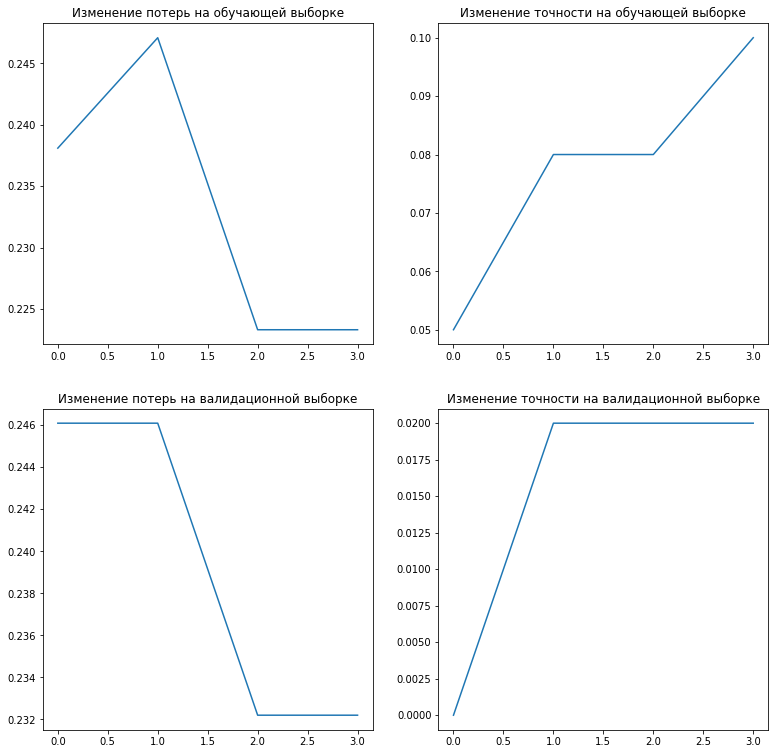

In [42]:
graf(loss, acc)